
ANOVA Table:
                           sum_sq     df           F         PR(>F)
C(Treatment)           27.916879    4.0  174.938814   6.240187e-98
C(Depth)               74.334333   10.0  186.323983  4.207574e-173
C(Day)                 74.251758    2.0  930.585004  5.321972e-181
C(Treatment):C(Depth)  27.526121   40.0   17.249016   3.088549e-74
C(Treatment):C(Day)    17.149758    8.0   53.733769   6.374135e-65
C(Depth):C(Day)        36.749576   20.0   46.057636  2.222627e-105
Residual               22.939742  575.0         NaN            NaN

Shapiro-Wilk Test for Normality:
Statistic = 0.9905, p-value = 0.0003

Levene’s Test for Homogeneity:
Statistic = 1.6667, p-value = 0.0000

Levene's test rejects H₀. Running Welch's ANOVA...

Welch’s ANOVA :
F-statistic = 238.3318, p-value = 0.0000

Significant Effects at α = 0.05:
                           sum_sq    df           F         PR(>F)
C(Treatment)           27.916879   4.0  174.938814   6.240187e-98
C(Depth)               74.334333

C:\Users\Kenneth\AppData\Local\Temp\ipykernel_12556\2432907232.py:145: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  levene_test = stats.levene(*[group["pH"].values for _, group in df_filtered.groupby(['Treatment', 'Depth', 'Day'])])



Tukey HSD Results:
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                 group2         meandiff p-adj   lower   upper  reject
------------------------------------------------------------------------------------
       Control_0_Day 1       Control_0_Day 16     -0.2 0.8558 -0.4711  0.0711  False
       Control_0_Day 1       Control_0_Day 64     -0.3 0.0066 -0.5711 -0.0289   True
       Control_0_Day 1       Control_10_Day 1     0.05    1.0 -0.2211  0.3211  False
       Control_0_Day 1      Control_10_Day 16   -0.275  0.039 -0.5461 -0.0039   True
       Control_0_Day 1      Control_10_Day 64     -0.1    1.0 -0.3711  0.1711  False
       Control_0_Day 1        Control_1_Day 1     0.05    1.0 -0.2211  0.3211  False
       Control_0_Day 1       Control_1_Day 16   -0.225 0.4872 -0.4961  0.0461  False
       Control_0_Day 1       Control_1_Day 64     -0.2 0.8558 -0.4711  0.0711  False
       Control_0_Day 1        Control_2_Day 

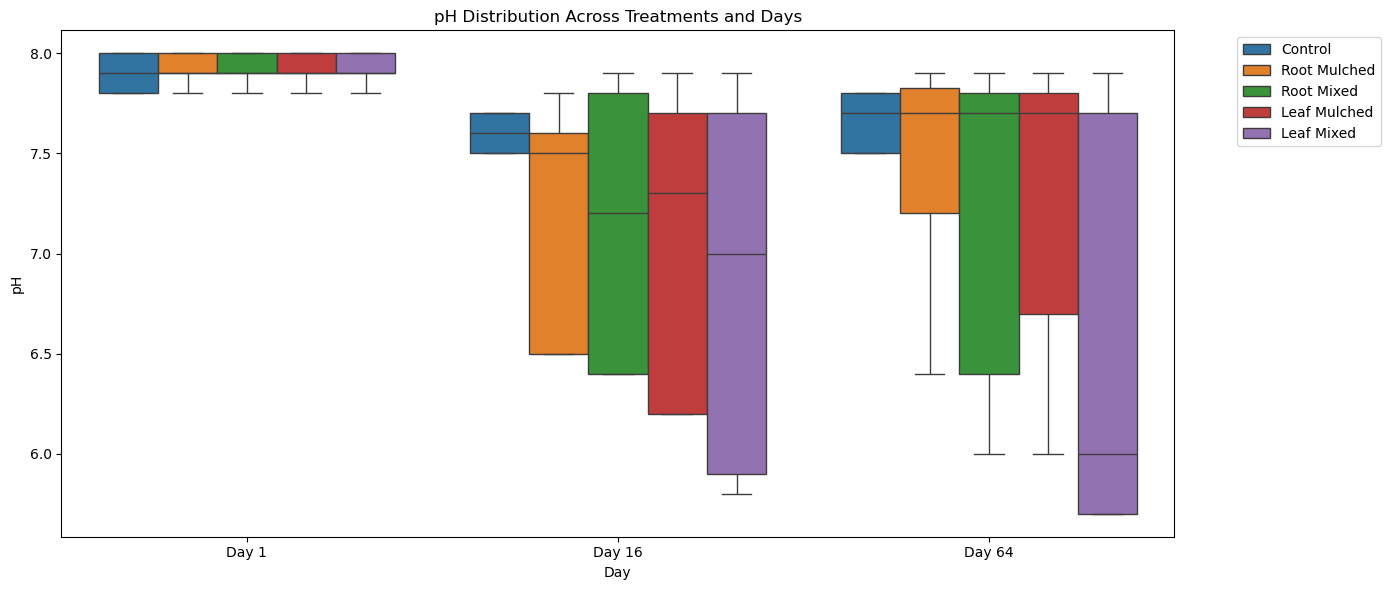

In [4]:
# ======================= Imports =======================
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# ======================= Data Setup =======================
# Define data dictionary and depths
data = {'Depth': [], 'pH': [], 'Treatment': [], 'Day': []}
depths = list(range(11))  # Depths 0 through 10

# Function to append pH measurements to the dataset
def add_treatment_data(treatment, day, depths, replicates):
    for depth_index, values in enumerate(replicates):
        for val in values:
            data['Depth'].append(depths[depth_index])
            data['pH'].append(val)
            data['Treatment'].append(treatment)
            data['Day'].append(day)


# pH values for Day 1 (each depth has 4 replicates)
control_day1 = [[7.8, 7.9, 7.8, 8.0], [7.9, 7.9, 8.0, 7.9], [7.9, 7.8, 7.9, 8.0], [8.0, 7.8, 8.0, 7.9],
                 [7.9, 8.0, 7.9, 7.8], [7.9, 8.0, 7.8, 7.8], [7.9, 7.8, 8.0, 7.9], [7.8, 8.0, 8.0, 7.8],
                 [7.8, 7.8, 8.0, 8.0], [7.9, 7.9, 7.9, 8.0], [8.0, 7.9, 8.0, 7.8]]

root_mulched_day1 = [[7.9, 7.8, 8.0, 8.0], [7.9, 8.0, 7.9, 7.8], [7.9, 7.9, 8.0, 8.0], [7.9, 7.9, 7.9, 8.0],
                 [7.8, 8.0, 7.9, 7.9], [7.8, 7.9, 8.0, 8.0], [7.9, 7.9, 8.0, 8.0], [8.0, 8.0, 7.8, 7.9],
                 [8.0, 8.0, 7.9, 7.8], [7.9, 7.8, 7.9, 8.0], [8.0, 8.0, 7.9, 8.0]]

root_mixed_day1 = [[7.8, 7.8, 7.9, 7.9], [8.0, 8.0, 7.8, 7.8], [7.9, 7.9, 8.0, 8.0], [7.9, 7.9, 8.0, 8.0],
                 [8.0, 8.0, 7.9, 7.9], [7.9, 7.9, 8.0, 8.0], [8.0, 8.0, 7.9, 7.8], [7.9, 8.0, 8.0, 7.8],
                 [7.9, 7.9, 8.0, 8.0], [7.9, 7.9, 8.0, 8.0], [8.0, 7.9, 7.9, 7.9]]

leaf_mulched_day1 = [[8.0, 7.9, 7.9, 8.0], [7.9, 7.8, 8.0, 8.0], [7.9, 7.9, 7.9, 8.0], [7.9, 8.0, 7.9, 7.9],
                 [8.0, 7.8, 8.0, 8.0], [8.0, 8.0, 7.9, 7.8], [7.9, 8.0, 8.0, 7.9], [7.9, 8.0, 7.9, 7.9],
                 [7.9, 8.0, 8.0, 7.9], [8.0, 8.0, 7.9, 7.8], [7.9, 7.9, 8.0, 8.0]]

leaf_mixed_day1 = [[8.0, 7.8, 7.8, 7.9], [7.8, 8.0, 8.0, 7.9], [8.0, 7.9, 7.9, 8.0], [7.9, 8.0, 7.9, 8.0],
                 [7.9, 8.0, 7.9, 7.9], [7.9, 7.9, 8.0, 7.9], [7.9, 7.9, 8.0, 8.0], [7.9, 7.9, 7.9, 8.0],
                 [8.0, 7.9, 7.8, 8.0], [8.0, 8.0, 8.0, 7.8], [7.9, 8.0, 8.0, 7.9]]

# pH values for Day 16 (each depth has 4 replicates)
control_day16 = [[7.7, 7.7, 7.7, 7.6], [7.7, 7.6, 7.6, 7.7], [7.5, 7.7, 7.6, 7.7], [7.6, 7.6, 7.7, 7.5],
                 [7.5, 7.6, 7.6, 7.7], [7.6, 7.7, 7.5, 7.5], [7.7, 7.5, 7.6, 7.5], [7.5, 7.7, 7.5, 7.6],
                 [7.5, 7.7, 7.5, 7.6], [7.7, 7.6, 7.5, 7.7], [7.6, 7.5, 7.7, 7.6]]


root_mulched_day16 = [[6.5, 6.5, 6.5, 6.5], [6.5, 6.5, 6.5, 6.5], [6.5, 6.5, 6.5, 6.5], [7.2, 7.2, 7.2, 7.2],
                       [7.5, 7.7, 7.6, 7.7], [7.7, 7.6, 7.5, 7.5], [7.6, 7.5, 7.7, 7.5], [7.7, 7.5, 7.6, 7.5],
                       [7.6, 7.5, 7.5, 7.6], [7.7, 7.5, 7.6, 7.8], [7.7, 7.5, 7.6, 7.8]]

root_mixed_day16 = [[6.4, 6.4, 6.4, 6.4], [6.4, 6.4, 6.4, 6.4], [6.4, 6.4, 6.4, 6.4], [6.5, 6.5, 6.5, 6.5],
                  [7.2, 7.2, 7.2, 7.2], [7.2, 7.2, 7.2, 7.2], [7.9, 7.9, 7.7, 7.7], [7.7, 7.7, 7.9, 7.8],
                  [7.8, 7.8, 7.8, 7.9], [7.8, 7.8, 7.9, 7.7], [7.7, 7.9, 7.9, 7.8]]

leaf_mulched_day16 = [[6.2, 6.2, 6.2, 6.2], [6.2, 6.2, 6.2, 6.2], [6.2, 6.2, 6.2, 6.2], [7.1, 7.1, 7.1, 7.1],
                       [7.2, 7.2, 7.2, 7.2], [7.3, 7.3, 7.3, 7.3], [7.7, 7.5, 7.7, 7.5], [7.6, 7.6, 7.5, 7.7],
                       [7.7, 7.8, 7.8, 7.7], [7.9, 7.8, 7.8, 7.9], [7.9, 7.9, 7.7, 7.8]]

leaf_mixed_day16 = [[5.8, 5.8, 5.8, 5.8], [5.8, 5.8, 5.8, 5.8], [5.9, 5.9, 5.9, 5.9], [6, 6, 6, 6],
                     [6.2, 6.2, 6.2, 6.2], [7, 7, 7, 7], [7.1, 7.1, 7.1, 7.1], [7.7, 7.7, 7.6, 7.5],
                     [7.7, 7.7, 7.8, 7.9], [7.9, 7.7, 7.7, 7.9], [7.9, 7.8, 7.8, 7.7]]

# pH values for Day 64 (each depth has 4 replicates)
control_day64 = [[7.5, 7.8, 7.5, 7.5], [7.8, 7.7, 7.5, 7.7], [7.8, 7.5, 7.7, 7.7], [7.6, 7.6, 7.7, 7.8],
                  [7.8, 7.8, 7.7, 7.5], [7.7, 7.5, 7.5, 7.7], [7.6, 7.7, 7.5, 7.8], [7.8, 7.8, 7.5, 7.5],
                  [7.5, 7.8, 7.8, 7.8], [7.8, 7.8, 7.7, 7.7], [7.8, 7.8, 7.7, 7.8]]

root_mulched_day64 = [[6.4, 6.4, 6.4, 6.4], [6.4, 6.4, 6.4, 6.4], [7.2, 7.2, 7.2, 7.2], [7.2, 7.2, 7.2, 7.2],
                       [7.2, 7.2, 7.2, 7.2], [7.8, 7.8, 7.9, 7.7], [7.7, 7.8, 7.9, 7.9], [7.9, 7.9, 7.7, 7.8],
                       [7.8, 7.9, 7.9, 7.9], [7.9, 7.7, 7.9, 7.7], [7.7, 7.9, 7.8, 7.7]]

root_mixed_day64 = [[6.0, 6.0, 6.0, 6.0], [6.3, 6.3, 6.3, 6.3], [6.4, 6.4, 6.4, 6.4], [7.0, 7.0, 7.0, 7.0],
                     [7.0, 7.0, 7.0, 7.0], [7.7, 7.7, 7.8, 7.9], [7.9, 7.9, 7.8, 7.7], [7.7, 7.9, 7.9, 7.7],
                     [7.8, 7.7, 7.8, 7.7], [7.8, 7.9, 7.7, 7.8], [7.9, 7.8, 7.8, 7.9]]

leaf_mulched_day64 = [[6, 6, 6, 6], [6.4, 6.4, 6.4, 6.4], [6.7, 6.7, 6.7, 6.7], [7, 7, 7, 7],
                       [7.1, 7.1, 7.1, 7.1], [7.7, 7.7, 7.8, 7.7], [7.7, 7.8, 7.8, 7.7], [7.9, 7.8, 7.8, 7.9],
                       [7.8, 7.8, 7.9, 7.7], [7.7, 7.9, 7.9, 7.8], [7.9, 7.9, 7.8, 7.8]]

leaf_mixed_day64 = [[5.7, 5.7, 5.7, 5.7], [5.7, 5.7, 5.7, 5.7], [5.7, 5.7, 5.7, 5.7], [5.9, 5.9, 5.9, 5.9],
                     [6.0, 6.0, 6.0, 7.0], [6.0, 6.0, 6.0, 6.0], [6.4, 6.4, 6.4, 6.4], [7.0, 7.0, 7.0, 7.0],
                     [7.9, 7.7, 7.7, 7.7], [7.7, 7.8, 7.8, 7.9], [7.9, 7.7, 7.8, 7.9]]



# Add all treatments and days
treatments = [
    ('Control', control_day1, control_day16, control_day64),
    ('Root Mulched', root_mulched_day1, root_mulched_day16, root_mulched_day64),
    ('Root Mixed', root_mixed_day1, root_mixed_day16, root_mixed_day64),
    ('Leaf Mulched', leaf_mulched_day1, leaf_mulched_day16, leaf_mulched_day64),
    ('Leaf Mixed', leaf_mixed_day1, leaf_mixed_day16, leaf_mixed_day64)
]
days = ['Day 1', 'Day 16', 'Day 64']

for treatment, d1, d16, d64 in treatments:
    add_treatment_data(treatment, 'Day 1', depths, d1)
    add_treatment_data(treatment, 'Day 16', depths, d16)
    add_treatment_data(treatment, 'Day 64', depths, d64)


# Prepare DataFrame
df = pd.DataFrame(data)
df['Depth'] = pd.Categorical(df['Depth'], categories=depths, ordered=True)


# Days to compare
days_to_compare = ['Day 1', 'Day 16', 'Day 64']


# ======================= ANOVA & Tukey Analysis =======================
# Filter data
df_filtered = df[df['Day'].isin(days)].copy()
df_filtered['Depth'] = df_filtered['Depth'].astype(int)

# --- Step 1: ANOVA (Full factorial with interactions) ---
df_filtered = df[df['Day'].isin(days_to_compare)].copy()

model = ols('pH ~ C(Treatment) * C(Depth) * C(Day)', data=df_filtered).fit()
anova_table = sm.stats.anova_lm(model, typ=2)


#model = ols('pH ~ C(Treatment) + C(Depth) + C(Day) + \
             C(Treatment):C(Depth) + C(Treatment):C(Day) + \
             C(Depth):C(Day)', data=df_filtered).fit()

#anova_table = sm.stats.anova_lm(model, typ=2)



print("\nANOVA Table:\n", anova_table)

# --- Step 2: Assumption Checks ---
# 2a. Normality (Shapiro-Wilk)
shapiro_test = stats.shapiro(model.resid)
print(f"\nShapiro-Wilk Test for Normality:\nStatistic = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

# 2b. Homogeneity (Levene's Test)
levene_test = stats.levene(*[group["pH"].values for _, group in df_filtered.groupby(['Treatment', 'Depth', 'Day'])])
print(f"\nLevene’s Test for Homogeneity:\nStatistic = {levene_test.statistic:.4f}, p-value = {levene_test.pvalue:.4f}")

# --- Step 2c: Use Welch's ANOVA if homogeneity is violated ---
df_filtered['Group'] = df_filtered['Treatment'] + '_' + df_filtered['Depth'].astype(str) + '_' + df_filtered['Day']

if levene_test.pvalue < 0.05:
    print("\nLevene's test rejects H₀. Running Welch's ANOVA...")
    welch_result = stats.f_oneway(
        *[group["pH"].values for _, group in df_filtered.groupby('Group')]
    )
    print(f"\nWelch’s ANOVA :\nF-statistic = {welch_result.statistic:.4f}, p-value = {welch_result.pvalue:.4f}")

# --- Step 3: Significant ANOVA Effects ---
alpha = 0.05
significant_results = anova_table[anova_table["PR(>F)"] < alpha]
print("\nSignificant Effects at α = 0.05:\n", significant_results)

# --- Step 4: Tukey HSD Test ---
df_filtered['Group'] = df_filtered['Treatment'] + '_' + df_filtered['Depth'].astype(str) + '_' + df_filtered['Day']
tukey = pairwise_tukeyhsd(endog=df_filtered['pH'], groups=df_filtered['Group'], alpha=0.05)
print("\nTukey HSD Results:\n", tukey.summary())

# --- Step 5: FDR Correction for Multiple Comparisons ---
#tukey_results = pd.DataFrame(tukey._results_table.data[1:], columns=tukey._results_table.data[0])
##tukey_results['p-adj (FDR)'] = multipletests(tukey_results['p-adj'], method='fdr_bh')[1]
#print("\nTukey HSD Results with FDR Correction:\n", tukey_results)

# --- Step 6: Visualization ---
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_filtered, x="Day", y="pH", hue="Treatment")
plt.title("pH Distribution Across Treatments and Days")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

